In [2]:
import pandas as pd
import sqlalchemy as sa
from pathlib import Path
from ConfigLoader import ConfigLoader
import os
import numpy as np
import matplotlib.pyplot as plt

#Выгрузка данных из postgres

config_path = os.path.join(os.getcwd(), "config.json")
config_loader = ConfigLoader(config_path)
config = config_loader.config

if config is None:
    raise RuntimeError("Не удалось загрузить конфиг. Проверь путь к config.json")

db_conf = config.get("database")
if db_conf is None:
    raise RuntimeError("В config.json отсутствует секция 'database'")

db_url = (
    f"postgresql://{db_conf['user']}:{db_conf['password']}"
    f"@{db_conf['host']}:{db_conf['port']}/{db_conf['dbname']}"
)

engine = sa.create_engine(db_url)

query_2023 = """
SELECT *
FROM public.sales
WHERE date_time::date BETWEEN '2023-01-01' AND '2023-12-31';
"""

sales = pd.read_sql(query_2023, engine)
sales["date_time"] = pd.to_datetime(sales["date_time"], errors="coerce")

print(f"Загружено {len(sales):,} строк за 2023 год")
sales.head()

Загружено 2,030,552 строк за 2023 год


,client_id,gender,product_id,quantity,price_per_item,discount_per_item,total_price,date_time
0,658080,M,31098,0,2436.0,1150.0,0.0,2023-01-01 07:29:29
1,373032,F,30569,66,72492.0,26530.0,3033492.0,2023-01-01 15:23:02
2,763585,M,37433,25,16733.0,1248.0,387125.0,2023-01-01 22:34:42
3,440961,M,35430,2,7871.0,7342.0,1058.0,2023-01-01 14:36:26
4,374596,F,11154,18,15883.0,12739.0,56592.0,2023-01-01 02:15:37


In [3]:
#Исследование структуры выгрузки

print(f"Форма датафрейма: {sales.shape[0]} строк × {sales.shape[1]} колонок\n")
print("Типы данных и количество ненулевых значений:")
print(sales.info())
print("\nПропуски по колонкам (%):")
missing = (sales.isna().sum() / len(sales) * 100).round(2)
print(missing[missing > 0].sort_values(ascending=False))
print("\nОписательная статистика по числовым переменным:")
print(sales.describe().T)
cat_cols = sales.select_dtypes(include='object').columns.tolist()
if len(cat_cols) > 0:
    print("\nКоличество уникальных значений по категориальным колонкам:")
    for col in cat_cols:
        uniq = sales[col].nunique()
        sample_vals = sales[col].dropna().unique()[:5]
        print(f"{col}: {uniq} уникальных, примеры: {sample_vals}")

print("\nДиапазон дат в выгрузке:")
print(f"От {sales['date_time'].min()} до {sales['date_time'].max()}")
dupes = sales.duplicated().sum()
print(f"\nКоличество полностью дублирующихся строк: {dupes}")


Форма датафрейма: 2030552 строк × 8 колонок

Типы данных и количество ненулевых значений:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030552 entries, 0 to 2030551
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   client_id          object        
 1   gender             object        
 2   product_id         object        
 3   quantity           int64         
 4   price_per_item     float64       
 5   discount_per_item  float64       
 6   total_price        float64       
 7   date_time          datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 123.9+ MB
None

Пропуски по колонкам (%):
Series([], dtype: float64)

Описательная статистика по числовым переменным:
                       count                           mean  \
quantity           2030552.0                       32.97777   
price_per_item     2030552.0                   49836.706691   
discount_per_item  2030552.0

In [4]:
df = sales.copy()
df["date"] = df["date_time"].dt.date
df["net_price_per_item"] = df["price_per_item"] - df["discount_per_item"]
df["revenue"] = df["total_price"]
df["discount_rate"] = np.where(
    df["price_per_item"] > 0,
    df["discount_per_item"] / df["price_per_item"],
    np.nan
)
product_agg = (
    df.groupby("product_id", as_index=False)
    .agg(
        units_sold=("quantity", "sum"),
        revenue=("revenue", "sum"),
        avg_price=("price_per_item", "mean"),
        avg_net_price=("net_price_per_item", "mean"),
        avg_discount_abs=("discount_per_item", "mean"),
        avg_discount_rate=("discount_rate", "mean"),
        transactions=("product_id", "count"),
        unique_clients=("client_id", "nunique")
    )
)
product_agg = product_agg[product_agg["units_sold"] > 0].copy()

print(product_agg.head())
print("Количество уникальных товаров:", len(product_agg))


  product_id  units_sold     revenue  avg_price  avg_net_price  \
0          0        1314  39823510.0    54389.0   28671.575758   
1          1        1375  33656559.0    47397.0   24127.500000   
2         10        1262  31638372.0    55068.0   23153.725000   
3        100        1350  29822232.0    52050.0   25149.136364   
4       1000        1470  54497303.0    84214.0   40410.953488   

   avg_discount_abs  avg_discount_rate  transactions  unique_clients  
0      25717.424242           0.472842            33              33  
1      23269.500000           0.490949            44              44  
2      31914.275000           0.579543            40              40  
3      26900.863636           0.516827            44              44  
4      43803.046512           0.520140            43              43  
Количество уникальных товаров: 50000


In [5]:
# ABC анализ

product_agg = product_agg.sort_values("revenue", ascending=False)
product_agg["revenue_cum_share"] = product_agg["revenue"].cumsum() / product_agg["revenue"].sum()

def abc_class(x):
    if x <= 0.8:
        return "A"
    elif x <= 0.95:
        return "B"
    else:
        return "C"

product_agg["abc_class"] = product_agg["revenue_cum_share"].apply(abc_class)

product_agg["abc_class"].value_counts()


abc_class
A    26996
B    11509
C    11495
Name: count, dtype: int64

In [6]:
# XYZ анализ

df["year_month"] = df["date_time"].dt.to_period("M")
monthly = (
    df.groupby(["product_id", "year_month"], as_index=False)
    .agg(units_sold=("quantity", "sum"))
)

# Коэффициент вариации по каждому товару
stab = (
    monthly.groupby("product_id")["units_sold"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

stab["cv"] = stab["std"] / stab["mean"]
# Для товаров с одной-двумя точками или нулевой средней CV неинформативен
stab.loc[(stab["count"] < 3) | (stab["mean"] == 0), "cv"] = np.nan

def xyz_class(cv):
    if pd.isna(cv):
        return "Z"
    if cv <= 0.3:
        return "X"
    elif cv <= 0.6:
        return "Y"
    else:
        return "Z"

stab["xyz_class"] = stab["cv"].apply(xyz_class)
product_agg = product_agg.merge(stab[["product_id", "cv", "xyz_class"]], on="product_id", how="left")

product_agg["xyz_class"].value_counts(dropna=False)


xyz_class
Z    27338
Y    22481
X      181
Name: count, dtype: int64

In [7]:
# ABC-XYZ анализ

product_agg["abc_xyz"] = product_agg["abc_class"].astype(str) + product_agg["xyz_class"].astype(str)
matrix_counts = product_agg["abc_xyz"].value_counts().sort_index()
print(matrix_counts)

abc_xyz
AX       92
AY    12568
AZ    14336
BX       40
BY     4933
BZ     6536
CX       49
CY     4980
CZ     6466
Name: count, dtype: int64


In [8]:
# Фильтрация явных выбросов по скидке, если есть (например, >100%)

df_valid_disc = df[
    (df["discount_rate"].notna()) &
    (df["discount_rate"] >= 0) &
    (df["discount_rate"] <= 1)
].copy()

# Агрегация по товару
disc_effect = (
    df_valid_disc.groupby("product_id", as_index=False)
    .agg(
        avg_discount_rate=("discount_rate", "mean"),
        units_sold=("quantity", "sum"),
        revenue=("revenue", "sum")
    )
)

# Корреляция по всей выборке
corr_discount_units = disc_effect["avg_discount_rate"].corr(disc_effect["units_sold"])
corr_discount_revenue = disc_effect["avg_discount_rate"].corr(disc_effect["revenue"])

print("Корреляция средней скидки и количества продаж по товарам:", corr_discount_units)
print("Корреляция средней скидки и выручки по товарам:", corr_discount_revenue)

# Объединяем в общий срез
product_agg = product_agg.merge(
    disc_effect[["product_id", "avg_discount_rate"]],
    on="product_id",
    how="left",
    suffixes=("", "_disc_calc")
)

# Для дальнейшего анализа можно выделить группы:
high_disc_low_sales = product_agg[
    (product_agg["avg_discount_rate"] > 0.3) &
    (product_agg["units_sold"] < product_agg["units_sold"].median())
]

low_disc_high_sales = product_agg[
    (product_agg["avg_discount_rate"] < 0.1) &
    (product_agg["units_sold"] > product_agg["units_sold"].median())
]

print("Товары с высокими скидками и ниже медианы по продажам:", len(high_disc_low_sales))
print("Товары с низкими скидками и выше медианы по продажам:", len(low_disc_high_sales))


Корреляция средней скидки и количества продаж по товарам: -0.00500299317443956
Корреляция средней скидки и выручки по товарам: -0.13893193886826435
Товары с высокими скидками и ниже медианы по продажам: 24947
Товары с низкими скидками и выше медианы по продажам: 0


In [9]:
# Топ-товары по выручке
top_revenue = product_agg.sort_values("revenue", ascending=False).head(20)

# Аутсайдеры по выручке (с фильтром, чтобы отсечь совсем единичные продажи при очень высокой цене)
bottom_revenue = product_agg.sort_values("revenue", ascending=True).head(50)

# Товары-кандидаты на вывод:
# низкая выручка, низкие продажи, нестабильный спрос (Z), категория C
candidates_for_exit = product_agg[
    (product_agg["abc_class"] == "C") &
    (product_agg["xyz_class"] == "Z") &
    (product_agg["units_sold"] <= product_agg["units_sold"].quantile(0.25))
].sort_values("revenue")

# Товары-кандидаты на усиление:
# A/X, высокая выручка, множество клиентов
candidates_for_push = product_agg[
    (product_agg["abc_class"] == "A") &
    (product_agg["xyz_class"] == "X") &
    (product_agg["unique_clients"] > product_agg["unique_clients"].median())
].sort_values("revenue", ascending=False).head(50)

print("Кандидаты на вывод:", len(candidates_for_exit))
print("Кандидаты на усиление:", len(candidates_for_push))


Кандидаты на вывод: 2450
Кандидаты на усиление: 50


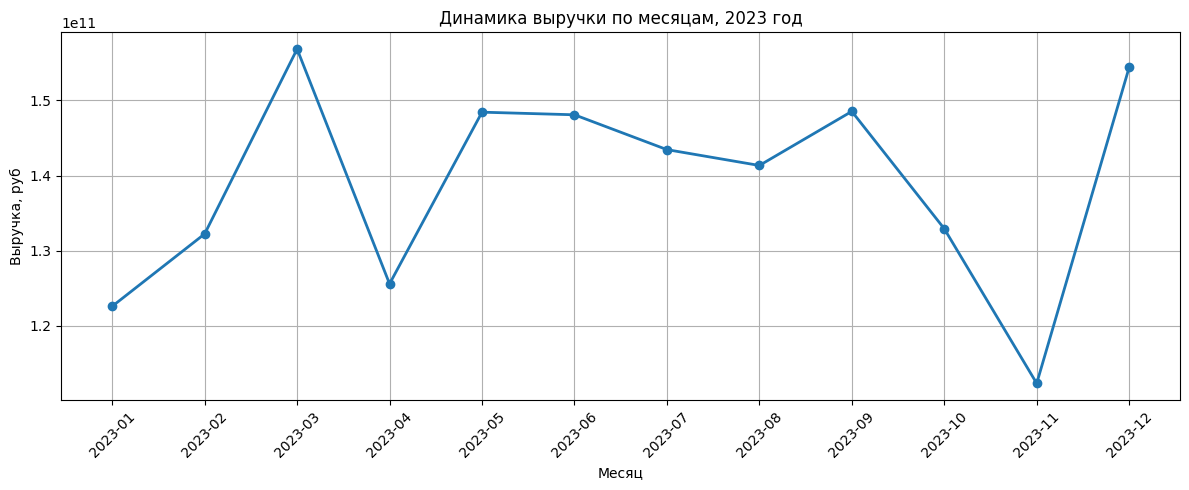

In [10]:
# Построение графика динамики выручки

monthly_sales = (
    df.groupby(df["date_time"].dt.to_period("M"))
      .agg(quantity=("quantity", "sum"), revenue=("total_price", "sum"))
      .reset_index()
)
monthly_sales["month"] = monthly_sales["date_time"].astype(str)

plt.figure(figsize=(12, 5))
plt.plot(monthly_sales["month"], monthly_sales["revenue"], marker='o', linewidth=2)
plt.title("Динамика выручки по месяцам, 2023 год")
plt.xlabel("Месяц")
plt.ylabel("Выручка, руб")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Анализируем индекс сезонности по месяцам

monthly = (
    df.groupby(df["date_time"].dt.to_period("M"))
      .agg(revenue=("total_price", "sum"))
      .reset_index()
)

monthly["month"] = monthly["date_time"].astype(str)

mean_rev = monthly["revenue"].mean()
monthly["season_index"] = monthly["revenue"] / mean_rev
monthly["dev_pct"] = (monthly["season_index"] - 1.0) * 100  # отклонение в %

monthly["abs_dev_pct"] = monthly["dev_pct"].abs()

top3_high = monthly.nlargest(3, "season_index")[["month", "revenue", "season_index", "dev_pct"]]
top3_low  = monthly.nsmallest(3, "season_index")[["month", "revenue", "season_index", "dev_pct"]]
top3_abs  = monthly.nlargest(3, "abs_dev_pct")[["month", "revenue", "season_index", "dev_pct"]]

pd.options.display.float_format = "{:,.2f}".format

print("Топ-3 месяцев по индексам сезонности (пики):")
print(top3_high.to_string(index=False))

print("\nТоп-3 месяцев по индексам сезонности (провалы):")
print(top3_low.to_string(index=False))

print("\nТоп-3 месяцев с максимальным абсолютным отклонением от среднего:")
print(top3_abs.to_string(index=False))


Топ-3 месяцев по индексам сезонности (пики):
  month            revenue  season_index  dev_pct
2023-03 156,822,223,504.00          1.13    12.90
2023-12 154,382,928,058.00          1.11    11.15
2023-09 148,531,264,357.00          1.07     6.93

Топ-3 месяцев по индексам сезонности (провалы):
  month            revenue  season_index  dev_pct
2023-11 112,366,474,435.00          0.81   -19.10
2023-01 122,616,102,220.00          0.88   -11.72
2023-04 125,599,189,747.00          0.90    -9.58

Топ-3 месяцев с максимальным абсолютным отклонением от среднего:
  month            revenue  season_index  dev_pct
2023-11 112,366,474,435.00          0.81   -19.10
2023-03 156,822,223,504.00          1.13    12.90
2023-01 122,616,102,220.00          0.88   -11.72


2. АНАЛИЗ КЛИЕНТСКОЙ БАЗЫ

In [12]:
import pandas as pd
import numpy as np

df = sales.copy()

df["date"] = df["date_time"].dt.date
df["month"] = df["date_time"].dt.to_period("M")
unique_clients = df["client_id"].nunique()
print(f"Количество уникальных клиентов за 2023 год: {unique_clients}")

client_summary = (
    df.groupby("client_id", as_index=False)
      .agg(
          total_revenue=("total_price", "sum"),
          total_orders=("date_time", "count"),
          avg_order_value=("total_price", "mean"),
          first_purchase=("date_time", "min"),
          last_purchase=("date_time", "max")
      )
)
client_summary["days_between_first_last"] = (
    (client_summary["last_purchase"] - client_summary["first_purchase"]).dt.days
)
client_summary.head()


Количество уникальных клиентов за 2023 год: 868785


,client_id,total_revenue,total_orders,avg_order_value,first_purchase,last_purchase,days_between_first_last
0,0,"1,302,858.00",1,"1,302,858.00",2023-12-14 19:23:35,2023-12-14 19:23:35,0
1,10,"7,017.00",1,"7,017.00",2023-12-30 16:18:04,2023-12-30 16:18:04,0
2,100,"1,111,585.00",3,"370,528.33",2023-07-07 11:16:47,2023-12-16 10:14:17,161
3,1000,"2,722,421.00",3,"907,473.67",2023-09-14 15:06:36,2023-10-03 20:33:25,19
4,10000,"5,041,962.00",3,"1,680,654.00",2023-11-04 18:21:06,2023-12-28 17:54:42,53


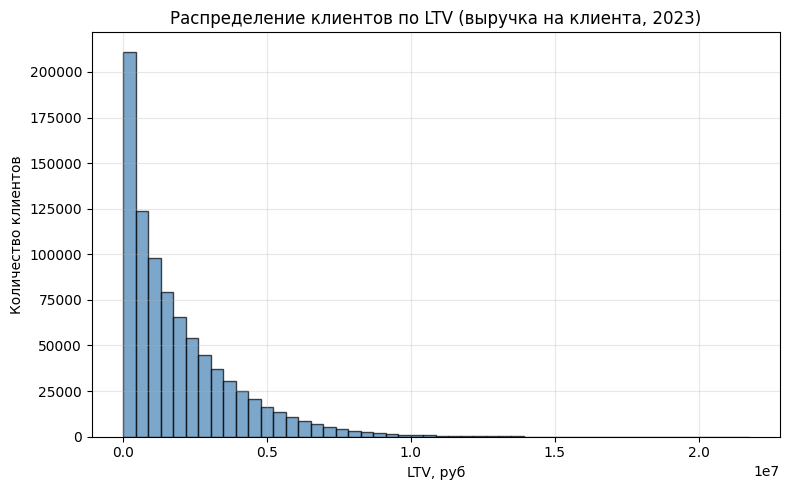

In [29]:
import matplotlib.pyplot as plt

ltv = df.groupby("client_id")["total_price"].sum()

plt.figure(figsize=(8,5))
plt.hist(ltv, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.title("Распределение клиентов по LTV (выручка на клиента, 2023)")
plt.xlabel("LTV, руб")
plt.ylabel("Количество клиентов")
plt.grid(alpha=0.3)
plt.tight_layout()


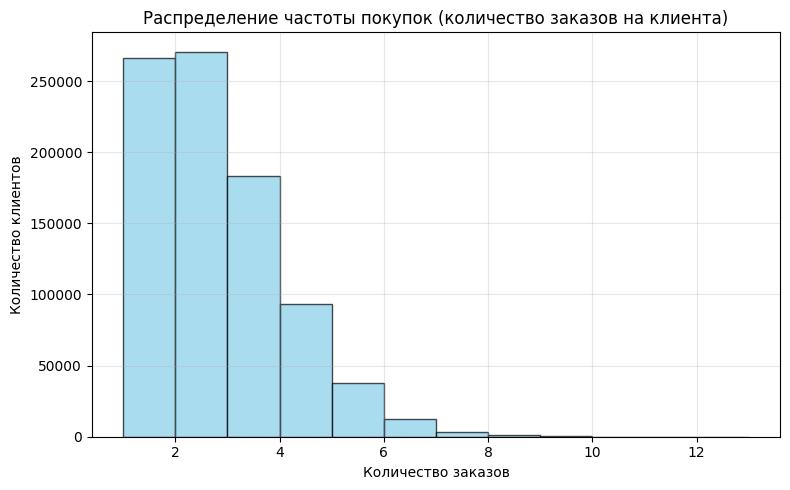

In [30]:
orders_per_client = df.groupby("client_id")["date_time"].count()

plt.figure(figsize=(8,5))
plt.hist(orders_per_client, bins=range(1, orders_per_client.max()+2),
         color="skyblue", edgecolor="black", alpha=0.7)
plt.title("Распределение частоты покупок (количество заказов на клиента)")
plt.xlabel("Количество заказов")
plt.ylabel("Количество клиентов")
plt.grid(alpha=0.3)
plt.tight_layout()


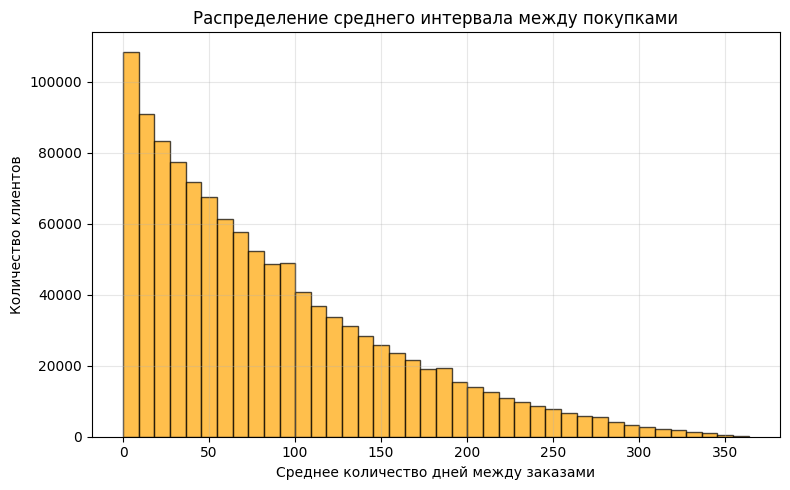

In [31]:
df_sorted = df.sort_values(["client_id", "date_time"])
df_sorted["days_between"] = df_sorted.groupby("client_id")["date_time"].diff().dt.days
intervals = df_sorted["days_between"].dropna()

plt.figure(figsize=(8,5))
plt.hist(intervals, bins=40, color="orange", edgecolor="black", alpha=0.7)
plt.title("Распределение среднего интервала между покупками")
plt.xlabel("Среднее количество дней между заказами")
plt.ylabel("Количество клиентов")
plt.grid(alpha=0.3)
plt.tight_layout()


In [15]:
# текущая дата = последний день наблюдения
current_date = df["date_time"].max() + pd.Timedelta(days=1)

rfm = df.groupby("client_id").agg({
    "date_time": lambda x: (current_date - x.max()).days,  # Recency
    "client_id": "count",                                  # Frequency
    "total_price": "sum"                                   # Monetary
}).rename(columns={"date_time": "Recency", "client_id": "Frequency", "total_price": "Monetary"})
quantiles = rfm.quantile(q=[0.33, 0.66]).to_dict()
def r_score(x):
    if x <= quantiles["Recency"][0.33]: return 3
    elif x <= quantiles["Recency"][0.66]: return 2
    else: return 1

def fm_score(x, metric):
    if x <= quantiles[metric][0.33]: return 1
    elif x <= quantiles[metric][0.66]: return 2
    else: return 3

rfm["R"] = rfm["Recency"].apply(r_score)
rfm["F"] = rfm["Frequency"].apply(lambda x: fm_score(x, "Frequency"))
rfm["M"] = rfm["Monetary"].apply(lambda x: fm_score(x, "Monetary"))

rfm["RFM_Segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)
rfm["RFM_Score"] = rfm[["R", "F", "M"]].sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
client_id,,,,,,,,
0,18,1,"1,302,858.00",3,1,2,312,6
10,2,1,"7,017.00",3,1,1,311,5
100,16,3,"1,111,585.00",3,2,2,322,7
1000,90,3,"2,722,421.00",2,2,3,223,7
10000,4,3,"5,041,962.00",3,2,3,323,8


In [18]:
# Доля выручки по товарам от клиентов с высоким RFM
top_clients = rfm[rfm["RFM_Score"] >= 7].index
df_top = df[df["client_id"].isin(top_clients)]
share_top = (
    df_top.groupby("product_id")["total_price"].sum() /
    df.groupby("product_id")["total_price"].sum()
).fillna(0)

top_sku = share_top.sort_values(ascending=False).head(20)
print(top_sku)


product_id
31497   0.95
4885    0.95
5975    0.93
33353   0.93
6066    0.93
30712   0.93
3558    0.92
35981   0.91
33840   0.91
5049    0.91
7326    0.91
9646    0.91
41709   0.91
47090   0.90
22989   0.90
17614   0.90
16666   0.90
2902    0.90
48793   0.90
31656   0.90
Name: total_price, dtype: float64


In [19]:
sleeping_clients = rfm[rfm["RFM_Score"] <= 4].index
df_sleep = df[df["client_id"].isin(sleeping_clients)]
share_top = (
    df_sleep.groupby("product_id")["total_price"].sum() /
    df.groupby("product_id")["total_price"].sum()
).fillna(0)

sleep_sku = share_top.sort_values(ascending=False).head(20)
print(sleep_sku)

product_id
47662   0.70
31183   0.68
12345   0.64
48165   0.63
3511    0.62
31781   0.60
15387   0.60
47001   0.60
7852    0.59
26203   0.58
1801    0.57
37601   0.57
10238   0.56
39307   0.56
34409   0.56
37149   0.56
23036   0.55
44735   0.55
43235   0.55
25033   0.55
Name: total_price, dtype: float64


Среднее количество покупок на клиента: 2.3372318813055015
Медианное количество покупок: 2.0


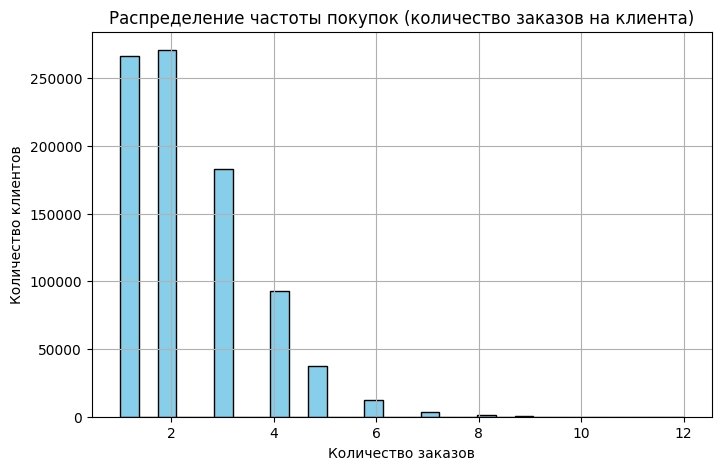

In [20]:
# частота = количество заказов на одного клиента за период
frequency = (
    df.groupby("client_id", as_index=False)
      .agg(total_orders=("date_time", "count"),
           total_revenue=("total_price", "sum"))
)

print("Среднее количество покупок на клиента:", frequency["total_orders"].mean())
print("Медианное количество покупок:", frequency["total_orders"].median())

# распределение частоты
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(frequency["total_orders"], bins=30, color="skyblue", edgecolor="black")
plt.title("Распределение частоты покупок (количество заказов на клиента)")
plt.xlabel("Количество заказов")
plt.ylabel("Количество клиентов")
plt.grid(True)
plt.show()


In [21]:
rfm_summary = rfm.copy().reset_index()
rfm_summary["client_id"] = rfm_summary["client_id"].astype(str)

# распределение клиентов по F-компоненте
rfm_summary["F_label"] = pd.qcut(rfm_summary["Frequency"], q=3, labels=["Low", "Medium", "High"])
rfm_summary["F_label"].value_counts()


F_label
Low       537082
Medium    183233
High      148470
Name: count, dtype: int64

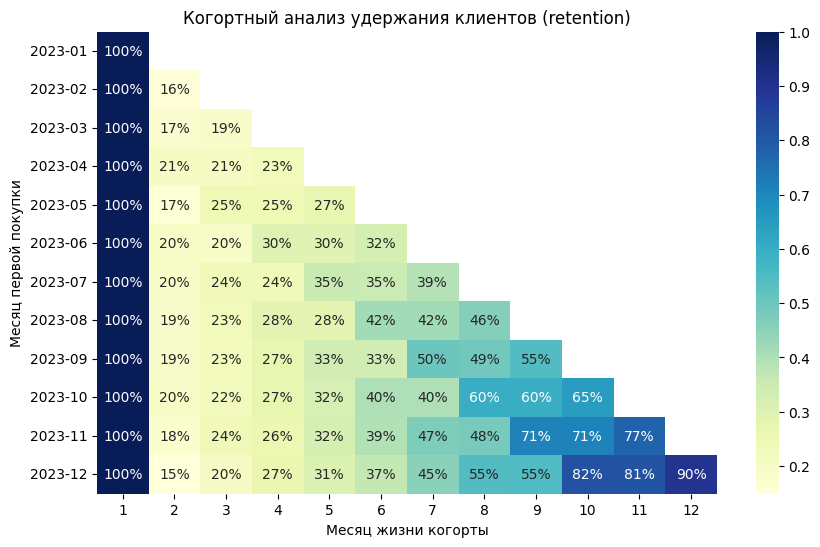

In [ ]:
df["cohort_month"] = df["date_time"].dt.to_period("M")
first_purchase = df.groupby("client_id")["cohort_month"].transform("min")
df["cohort_index"] = (df["cohort_month"].dt.year - first_purchase.dt.year) * 12 + (df["cohort_month"].dt.month - first_purchase.dt.month) + 1

cohort_data = df.groupby(["cohort_month", "cohort_index"])["client_id"].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index="cohort_month", columns="cohort_index", values="client_id")

cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

plt.figure(figsize=(10,6))
import seaborn as sns
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Когортный анализ удержания клиентов (retention)")
plt.xlabel("Месяц жизни когорты")
plt.ylabel("Месяц первой покупки")
plt.show()


In [17]:
avg_revenue_per_client = client_summary["total_revenue"].mean()
avg_orders_per_client = client_summary["total_orders"].mean()
avg_retention = retention.iloc[:,1:].mean().mean()  # средний retention по когортам

ltv = avg_revenue_per_client * avg_retention
print(f"Оценка среднего LTV клиента: {ltv:,.0f} руб.")


Оценка среднего LTV клиента: 927,493 руб.


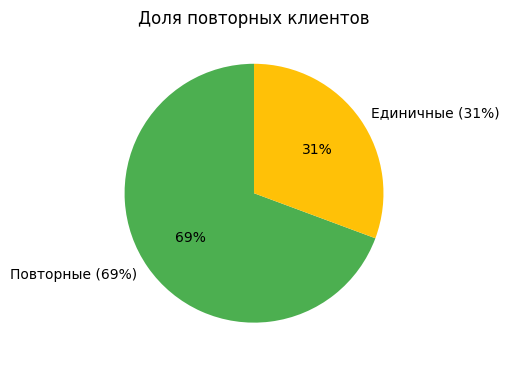

In [ ]:
repeat_rate = (orders_per_client > 1).mean()
plt.figure(figsize=(5,5))
plt.pie([repeat_rate, 1-repeat_rate],
        labels=[f"Повторные ({repeat_rate:.0%})", f"Единичные ({1-repeat_rate:.0%})"],
        colors=["#4CAF50", "#FFC107"],
        autopct="%1.0f%%", startangle=90)
plt.title("Доля повторных клиентов")
plt.tight_layout()


In [25]:
gender_stats = (
    df.groupby("gender", as_index=False)
      .agg(
          clients=("client_id", "nunique"),
          orders=("date_time", "count"),
          total_revenue=("total_price", "sum"),
          avg_order_value=("total_price", "mean"),
          avg_quantity=("quantity", "mean")
      )
)

gender_stats["revenue_share"] = gender_stats["total_revenue"] / gender_stats["total_revenue"].sum()
print(gender_stats)


  gender  clients   orders      total_revenue  avg_order_value  avg_quantity  \
0      F   434089  1015681 833,552,564,076.00       820,683.43         32.98   
1      M   434696  1014871 833,238,916,188.00       821,029.39         32.98   

   revenue_share  
0           0.50  
1           0.50  


In [26]:
rfm_gender = (
    rfm.reset_index()
    .merge(df[["client_id", "gender"]].drop_duplicates(), on="client_id", how="left")
    .groupby("gender")[["R", "F", "M"]]
    .mean()
    .round(2)
)
print(rfm_gender)


          R    F    M
gender               
F      2.00 1.55 2.01
M      2.00 1.55 2.01


In [27]:
client_gender = (
    df.groupby("client_id", as_index=False)
      .agg(revenue=("total_price", "sum"),
           orders=("date_time", "count"),
           gender=("gender", "first"))
)

ltv_gender = client_gender.groupby("gender")["revenue"].mean()
freq_gender = client_gender.groupby("gender")["orders"].mean()

print("Средний LTV по полу:")
print(ltv_gender)
print("\nСредняя частота заказов по полу:")
print(freq_gender)


Средний LTV по полу:
gender
F   1,920,234.25
M   1,916,831.34
Name: revenue, dtype: float64

Средняя частота заказов по полу:
gender
F   2.34
M   2.33
Name: orders, dtype: float64


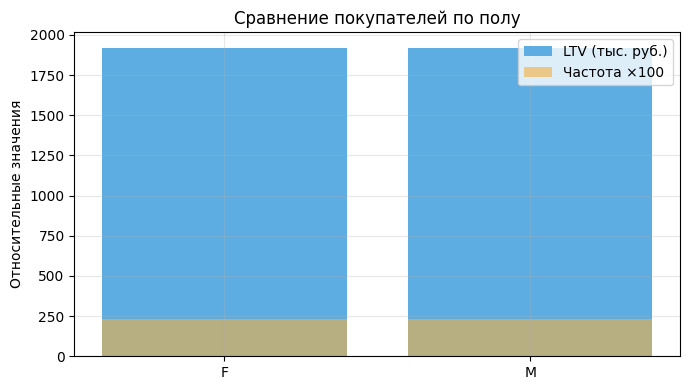

In [34]:
ltv_gender = client_gender.groupby("gender")["revenue"].mean()
freq_gender = client_gender.groupby("gender")["orders"].mean()

plt.figure(figsize=(7,4))
plt.bar(ltv_gender.index, ltv_gender.values/1000, color="#5DADE2", label="LTV (тыс. руб.)")
plt.bar(freq_gender.index, freq_gender.values*100, alpha=0.6, color="#F5B041", label="Частота ×100")
plt.title("Сравнение покупателей по полу")
plt.ylabel("Относительные значения")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
